In [0]:
%pip install pandas numpy matplotlib scikit-learn

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, stddev, avg, log, when, lit
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, DoubleType, StringType, TimestampType
import matplotlib.pyplot as plt
import requests
import pandas as pd
from datetime import datetime, timedelta

from pyspark.sql.functions import pandas_udf, PandasUDFType

#clustering
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

In [0]:
symbol =  "AAPL"
api_key = "UDEJQ3FLFIY9BVVT"

In [0]:
spark = SparkSession.builder.appName("AAPL_Prediction").getOrCreate()

In [0]:
def get_alpha_vantage_data(symbol, key):
    function = 'TIME_SERIES_DAILY'
    output_size = 'full'
    url = f'https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize={output_size}&apikey={key}'

    r = requests.get(url)
    data = r.json()

    if 'Time Series (Daily)' in data:
        df = pd.DataFrame(data['Time Series (Daily)']).T
        df.index = pd.to_datetime(df.index)
        df.sort_index(inplace=True)
        df.columns = [col.split('. ')[1] for col in df.columns]
        df = df.apply(pd.to_numeric)
        df = df[df.index >= datetime.now() - timedelta(days=365*20)]

        # Filtersy for data up to 18th of May 2025
        cutoff_date = pd.Timestamp('2025-05-18')
        df = df[df.index <= cutoff_date]

        df.reset_index(inplace=True)
        df.rename(columns={'index': 'Date'}, inplace=True)
        return spark.createDataFrame(df)
    else:
        raise Exception("Alpha Vantage API Error")


In [0]:
spark_df = get_alpha_vantage_data(symbol, api_key)

#### Visualization of the data

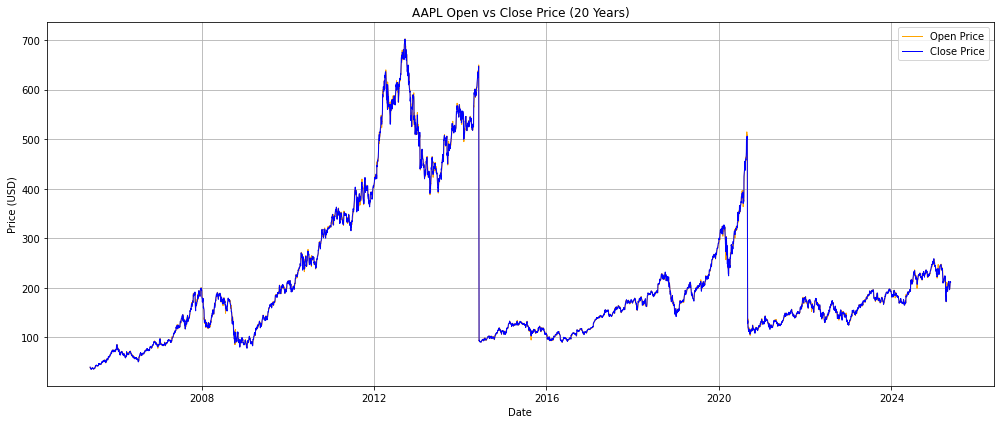

In [0]:
pandas_df = spark_df.select("Date", "close", "open").orderBy("Date").toPandas()

plt.figure(figsize=(14, 6))
plt.plot(pandas_df['Date'], pandas_df['open'], label='Open Price', color='orange', linewidth=1)
plt.plot(pandas_df['Date'], pandas_df['close'], label='Close Price', color='blue', linewidth=1)
plt.title('AAPL Open vs Close Price (20 Years)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Based on the plots above we can see that prices drastically changed in 2014 and 2020. After conducting the research we found out that apple stocks have been split. Thus, we update our data to include those splits. (source:https://www.ig.com/en/trading-strategies/apple-stock-split-2020--what-you-need-to-know-230803)

#### 

In [0]:
splits = {
    '2005-02-28': 2, # two-for-one stock split on 28 February 2005
    '2014-06-09': 7, #  seven-for-one stock split on 9th of June 2014
    '2020-08-31': 4. #  four-for-one stock split on 31st of August 2020
}

for split_date_str, stock_split in splits.items():
    split_date = datetime.strptime(split_date_str, "%Y-%m-%d")
    
    # Adjust prices before split date
    spark_df = spark_df.withColumn(
        'open',
        when(col('Date') < lit(split_date), col('open') / stock_split).otherwise(col('open'))
    ).withColumn(
        'high',
        when(col('Date') < lit(split_date), col('high') / stock_split).otherwise(col('high'))
    ).withColumn(
        'low',
        when(col('Date') < lit(split_date), col('low') / stock_split).otherwise(col('low'))
    ).withColumn(
        'close',
        when(col('Date') < lit(split_date), col('close') / stock_split).otherwise(col('close'))
    ).withColumn(
        'volume',
        when(col('Date') < lit(split_date), col('volume') * stock_split).otherwise(col('volume'))
    )


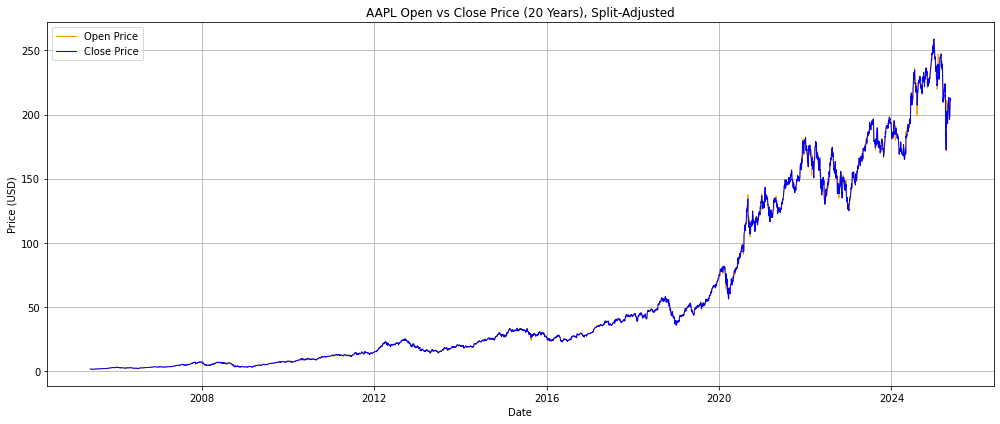

In [0]:
pandas_df = spark_df.select("Date", "close", "open").orderBy("Date").toPandas()

plt.figure(figsize=(14, 6))
plt.plot(pandas_df['Date'], pandas_df['open'], label='Open Price', color='orange', linewidth=1)
plt.plot(pandas_df['Date'], pandas_df['close'], label='Close Price', color='blue', linewidth=1)
plt.title('AAPL Open vs Close Price (20 Years), Split-Adjusted')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Feature engineering 

Newly created features
| Feature Name    | Description                                                                 |
|----------------|-----------------------------------------------------------------------------|
| window30      | 30-row rolling window |
| window7        | 7-row rolling window |     
| return        | daily percentage change between open and close (price change relative to opening price) |
| log_return   | Logarithmic return between the current day’s closing price and the previous day’s closing price  |
| volatility_30 | volatility measures how much the price of an asset fluctuates over time (in this case in 30 days) |
| ma_7         | 7-day moving average of closing prices (short-term trend) |
| ma_30         | 30-day moving average of closing prices (longer-term trend)  |
| volume_ma_7   | 7-day moving average of volume (detect unusual trading activity) |


rolling_window: https://trendspider.com/learning-center/enhancing-your-trading-strategy-with-rolling-window-indicators/

In [0]:
window30 = Window.orderBy("Date").rowsBetween(-30, -1)
window7 = Window.orderBy("Date").rowsBetween(-7, -1)

spark_df = spark_df.withColumn("return", (col("close") - col("open")) / col("open"))
spark_df = spark_df.withColumn("log_return", log(col("close") / lag("close", 1).over(Window.orderBy("Date"))))
spark_df = spark_df.withColumn("volatility_30", stddev("return").over(window30))
spark_df = spark_df.withColumn("ma_7", avg("close").over(window7))
spark_df = spark_df.withColumn("ma_30", avg("close").over(window30))
spark_df = spark_df.withColumn("volume_ma_7", avg("volume").over(window7))

spark_df = spark_df.na.drop()

display(spark_df.limit(5))

Date,open,high,low,close,volume,return,log_return,volatility_30,ma_7,ma_30,volume_ma_7
2005-06-03T00:00:00.000+0000,1.3628571428571428,1.377857142857143,1.3489285714285715,1.3657142857142859,9.568692E8,0.002096436058700398,-0.0459968662638191,0.007444387042825286,1.434642857142857,1.434642857142857,4.138932E8
2005-06-06T00:00:00.000+0000,1.3689285714285713,1.3796428571428572,1.3414285714285714,1.3542857142857143,8.119664E8,-0.010696582311505214,-0.008403410796379615,0.00552697058445035,1.4116666666666668,1.4116666666666668,5.948852E8
2005-06-07T00:00:00.000+0000,1.342857142857143,1.3475,1.3017857142857143,1.305,7.452648E8,-0.028191489361702255,-0.037071126436960485,0.008641120560452588,1.3973214285714286,1.3973214285714286,6.491555E8
2005-06-08T00:00:00.000+0000,1.3082142857142858,1.3303571428571428,1.3060714285714285,1.3185714285714287,4.040064E8,0.00791700791700799,0.010345858684790996,0.014798858167481596,1.3788571428571428,1.3788571428571428,6.6837736E8
2005-06-09T00:00:00.000+0000,1.3214285714285714,1.355,1.314957142857143,1.344642857142857,3.902556E8,0.017567567567567506,0.019579544611251058,0.01430217103730032,1.3688095238095237,1.3688095238095237,6.243155333333334E8


Visualisations of newly created features

In [0]:
pandas_df = spark_df.select("Date", "close", "return","ma_7","ma_30","volatility_30","log_return").orderBy("Date").toPandas()


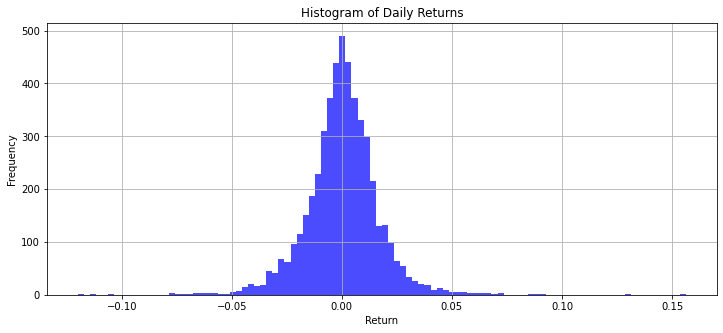

In [0]:

plt.figure(figsize=(12, 5))
plt.hist(pandas_df['return'].dropna(), bins=100, alpha=0.7, color='blue')
plt.title('Histogram of Daily Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

%md
* Most daily returns are small, the stock doesnt usually change much in one day
* There are occasional negative or positive returns - these can represent volatile days or extreme events like 2008 market crash or COVID in 2020
* Symmetric shape which suggest that returns are normally distributed

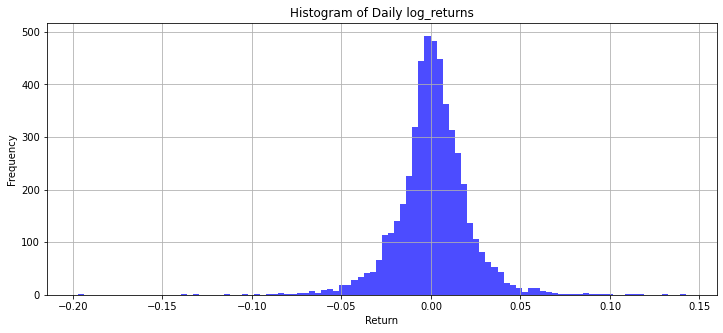

In [0]:

plt.figure(figsize=(12, 5))
plt.hist(pandas_df['log_return'].dropna(), bins=100, alpha=0.7, color='blue')
plt.title('Histogram of Daily log_returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

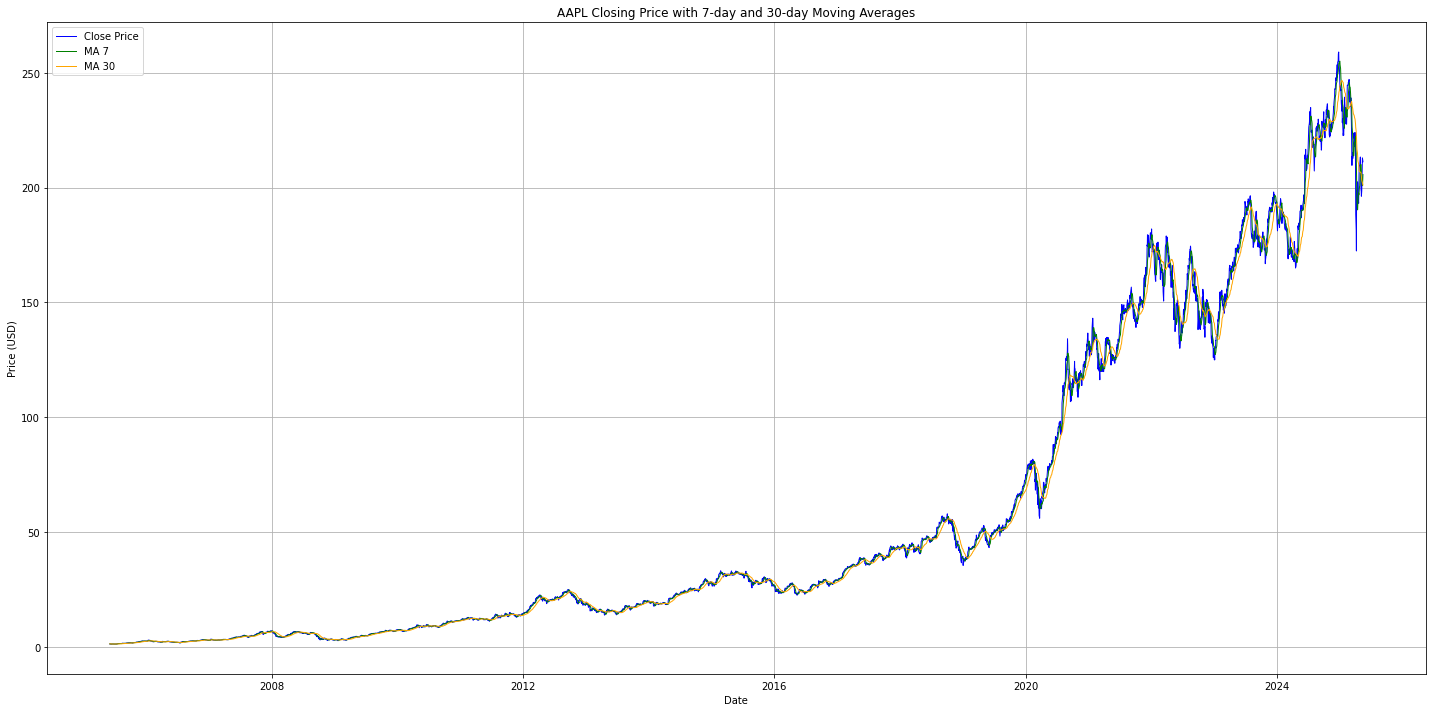

In [0]:
plt.figure(figsize=(20, 10))
plt.plot(pandas_df['Date'], pandas_df['close'], label='Close Price', color='blue', linewidth=1)
plt.plot(pandas_df['Date'], pandas_df['ma_7'], label='MA 7', color='green', linewidth=1)
plt.plot(pandas_df['Date'], pandas_df['ma_30'],label='MA 30', color='orange', linewidth=1)
plt.title('AAPL Closing Price with 7-day and 30-day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

%md
* Apple’s closing price has increased dramatically
* When ma_7 crosses above ma_30, it's a bullish signal (uptrend forming). When it crosses below, it's bearish (downtrend forming)
* Sharp rises or drops in the price line suggest high volatility, especially visible before and after COVID in 2020 and in recent market corrections.

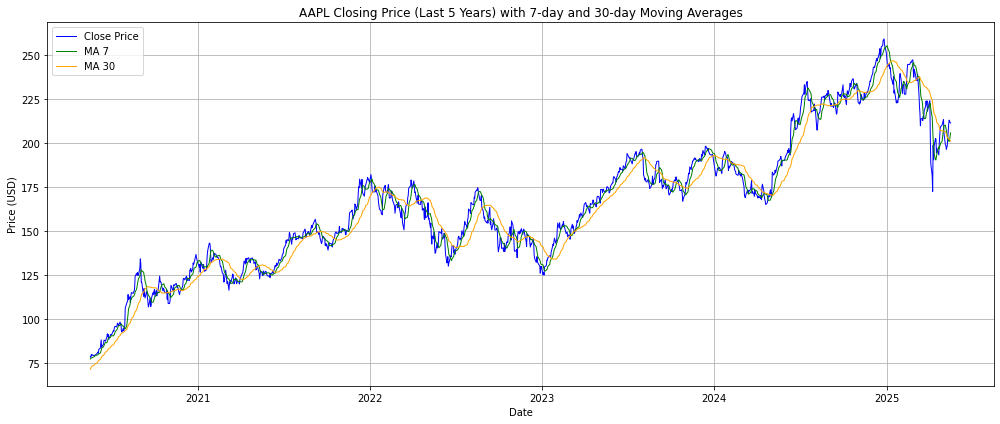

In [0]:
# Filter last 5 years only
cutoff_date = pandas_df['Date'].max() - pd.Timedelta(days=365*5)
plot_df = pandas_df[pandas_df['Date'] >= cutoff_date]

plt.figure(figsize=(14, 6))
plt.plot(plot_df['Date'], plot_df['close'], label='Close Price', color='blue', linewidth=1)
plt.plot(plot_df['Date'], plot_df['ma_7'], label='MA 7', color='green', linewidth=1)
plt.plot(plot_df['Date'], plot_df['ma_30'], label='MA 30', color='orange', linewidth=1)
plt.title('AAPL Closing Price (Last 5 Years) with 7-day and 30-day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

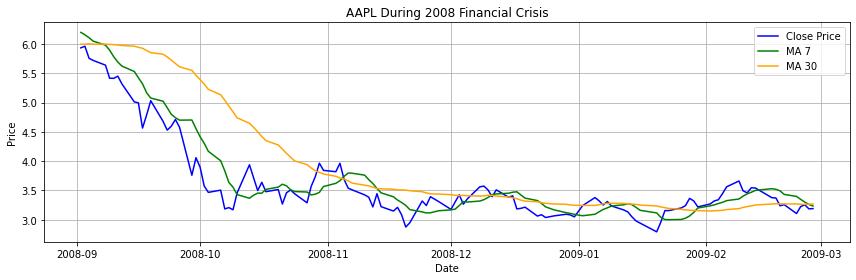

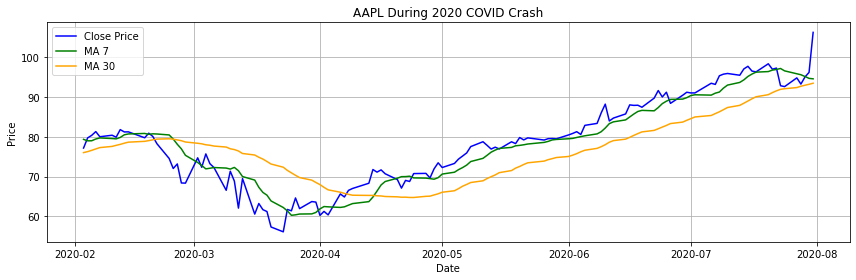

In [0]:
for label, start, end in [
    ("2008 Financial Crisis", "2008-09-01", "2009-03-01"),
    ("2020 COVID Crash", "2020-02-01", "2020-08-01")
]:
    zoom_df = pandas_df[(pandas_df['Date'] >= start) & (pandas_df['Date'] <= end)]
    plt.figure(figsize=(12, 4))
    plt.plot(zoom_df['Date'], zoom_df['close'], label='Close Price', color='blue')
    plt.plot(zoom_df['Date'], zoom_df['ma_7'], label='MA 7', color='green')
    plt.plot(zoom_df['Date'], zoom_df['ma_30'], label='MA 30', color='orange')
    plt.title(f'AAPL During {label}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
 

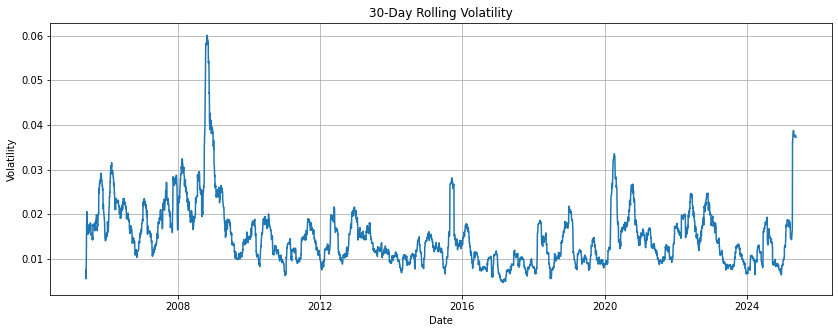

In [0]:
# --- Plot volatility with event annotations ---
plt.figure(figsize=(14, 5))
plt.plot(pandas_df['Date'], pandas_df['volatility_30'])
plt.title('30-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)
plt.show()

* Spikes in Volatility corresponds to market crises — 2008 financial crash, COVID crash. This is when market risk and investor uncertainty were extremely high
* Recurring smaller spikes - Could represent earnings reports, product launches, macroeconomic shocks, etc.

### Trend indicators

-------
 
Simple Moving Average (SMA)
 
Exponential Moving Average (EMA)
 
Hull Moving Average (HMA)

The window size in moving averages defines how many past data points are used to calculate each value of the average. Choosing the right window size depends on the trading strategy, time horizon, and market volatility you're analyzing.

| Window Size                  | Effect                                                                                               |
| ---------------------------- | ---------------------------------------------------------------------------------------------------- |
| **Small (e.g. 5, 10)**       | Follows the price closely, **captures short-term trends**, but is more sensitive to noise.           |
| **Medium (e.g. 14, 20)**     | A balance between smoothness and responsiveness. Common in many trading strategies.                  |
| **Large (e.g. 30, 50, 200)** | Smoother curves, **better for long-term trend analysis**, but lags more behind recent price changes. |


In [0]:
# Define window size
sma_window = 14
ema_window = 14
hma_window = 14

# Define window specs
window_spec = Window.orderBy("Date").rowsBetween(-(sma_window - 1), 0)


SMA

In [0]:
spark_df = spark_df.withColumn(f"SMA_{sma_window}", avg("close").over(window_spec))


EMA

In [0]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf("double", PandasUDFType.SCALAR)
def ema_udf(close: pd.Series) -> pd.Series:
    return close.ewm(span=ema_window, adjust=False).mean()

spark_df = spark_df.withColumn(f"EMA_{ema_window}", ema_udf(col("close")))


/databricks/spark/python/pyspark/sql/pandas/functions.py:396: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


HMA

HMA(n) = WMA(2 * WMA(n/2) − WMA(n)), sqrt(n)


Firs convert spark_df to panda_df

In [0]:
panda_df = spark_df.select("Date", "close").orderBy("Date").toPandas()

In [0]:
# Weighted Moving Average (WMA) Function
def weighted_moving_average(series: pd.Series, window: int) -> pd.Series:
    weights = np.arange(1, window + 1)
    return series.rolling(window).apply(lambda x: np.dot(x, weights[-len(x):]) / weights[-len(x):].sum(), raw=True)


In [0]:
import numpy as np
n = 14
wma_half = weighted_moving_average(panda_df["close"], int(n / 2))
wma_full = weighted_moving_average(panda_df["close"], n)

hma_intermediate = 2 * wma_half - wma_full
hma = weighted_moving_average(hma_intermediate, int(np.sqrt(n)))

# Add to DataFrame
panda_df[f"HMA_{n}"] = hma


In [0]:
print(panda_df[[ "Date", "close", f"HMA_{n}" ]].tail())


           Date   close      HMA_14
5016 2025-05-12  210.79  197.239294
5017 2025-05-13  212.93  200.822405
5018 2025-05-14  212.33  205.345397
5019 2025-05-15  211.45  209.196984
5020 2025-05-16  211.26  212.033262


In [0]:
def plot_moving_averages(df, date_col="Date", price_col="close", ma_cols=None, title="Stock Price with Moving Averages", figsize=(14, 6)):
    """
    Plots the stock closing price along with selected moving averages.
    
    Parameters:
    - df: Pandas DataFrame containing the data.
    - date_col: Name of the datetime column.
    - price_col: Name of the column with stock prices.
    - ma_cols: List of column names for moving averages to plot.
    - title: Title of the plot.
    - figsize: Tuple defining the size of the figure.
    """
    if ma_cols is None:
        ma_cols = [col for col in df.columns if "MA" in col or "ma" in col]
    
    plt.figure(figsize=figsize)
    plt.plot(df[date_col], df[price_col], label="Close Price", linewidth=1.5, alpha=0.7)

    for col in ma_cols:
        if col in df.columns:
            plt.plot(df[date_col], df[col], label=col, linewidth=2)

    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Plot the results 

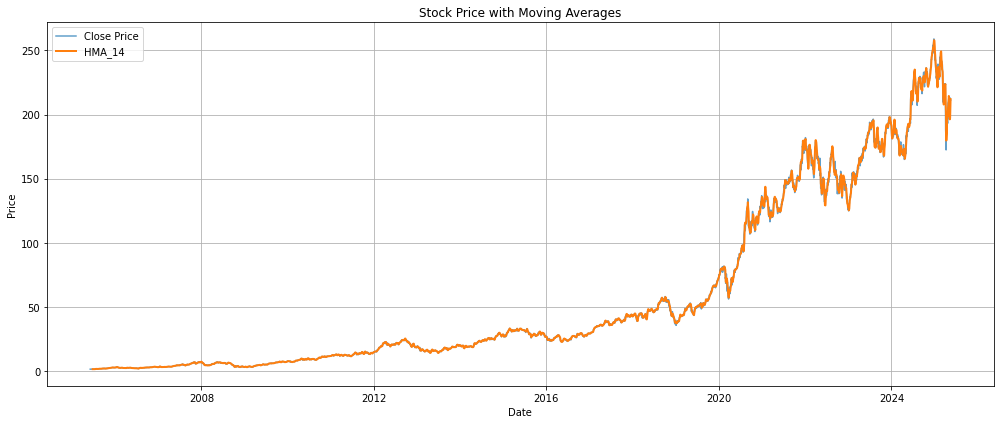

In [0]:
plot_moving_averages(panda_df, ma_cols=["SMA_14", "EMA_14", "HMA_14"])


In [0]:
spark_df

Out[26]: DataFrame[Date: timestamp, open: double, high: double, low: double, close: double, volume: double, return: double, log_return: double, volatility_30: double, ma_7: double, ma_30: double, volume_ma_7: double, SMA_14: double, EMA_14: double]

## Clustering for the EDA

To gain better insights into the past 20 years of Apple’s stock prices, we applied clustering techniques to group periods with similar market behavior. This  approach helps us identify hidden patterns or unusual events that may not be clearly visible through traditional analysis.

In [0]:
#selecting features to cluster on
assembler = VectorAssembler(inputCols=['return', 'volatility_30', 'volume_ma_7'], outputCol="features")
cluster_data = assembler.transform(spark_df)


kmeans = KMeans(k=3, seed=42)
model = kmeans.fit(cluster_data)


print("Cluster centers:")
for center in model.clusterCenters():
    print(center)

result = model.transform(cluster_data)
result.select("Date", "close", "return", "volatility_30", "volume_ma_7", "prediction").show(5)


Cluster centers:
[8.58866315e-04 1.28595438e-02 1.35795285e+08]
[-3.19075252e-04  1.59086101e-02  5.75966089e+08]
[-1.20792549e-03  2.52062237e-02  1.15614803e+09]
+-------------------+------------------+--------------------+--------------------+-------------------+----------+
|               Date|             close|              return|       volatility_30|        volume_ma_7|prediction|
+-------------------+------------------+--------------------+--------------------+-------------------+----------+
|2005-06-03 00:00:00|1.3657142857142859|0.002096436058700398|0.007444387042825286|         4.138932E8|         1|
|2005-06-06 00:00:00|1.3542857142857143|-0.01069658231150...| 0.00552697058445035|         5.948852E8|         1|
|2005-06-07 00:00:00|             1.305|-0.02819148936170...|0.008641120560452588|         6.491555E8|         1|
|2005-06-08 00:00:00|1.3185714285714287| 0.00791700791700799|0.014798858167481596|        6.6837736E8|         1|
|2005-06-09 00:00:00| 1.34464285714285

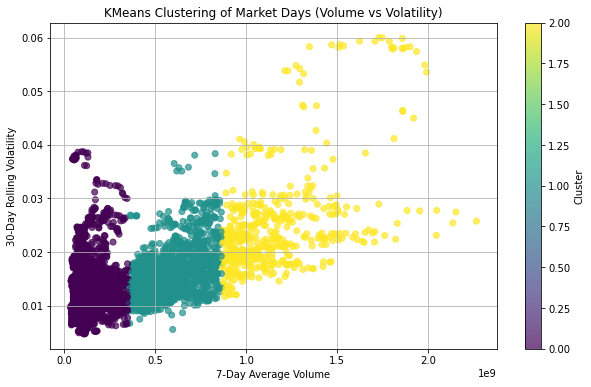

In [0]:
plot_df = result.select("Date", "return", "volatility_30", "volume_ma_7", "prediction").toPandas()

plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    plot_df["volume_ma_7"],
    plot_df["volatility_30"],
    c=plot_df["prediction"],
    cmap="viridis",
    alpha=0.7
)

plt.title("KMeans Clustering of Market Days (Volume vs Volatility)")
plt.xlabel("7-Day Average Volume")
plt.ylabel("30-Day Rolling Volatility")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()


In [0]:
result.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 1473|
|         0| 3035|
|         2|  513|
+----------+-----+



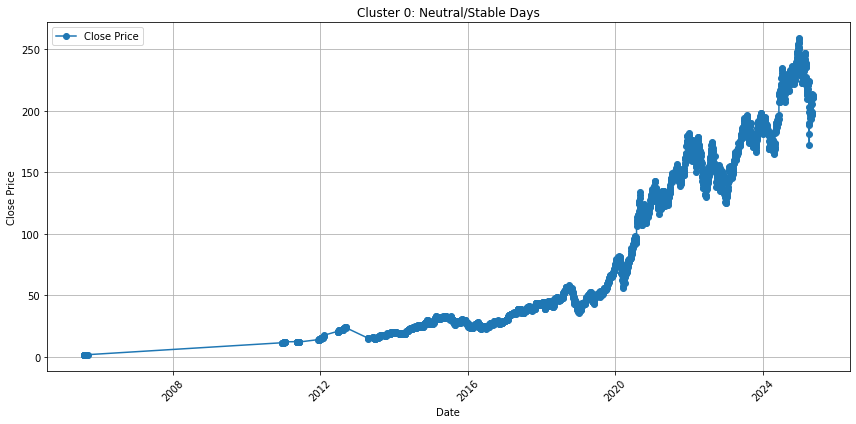

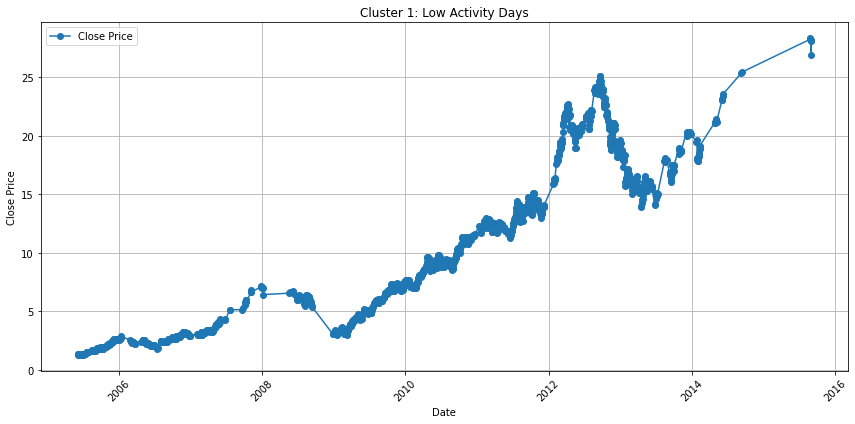

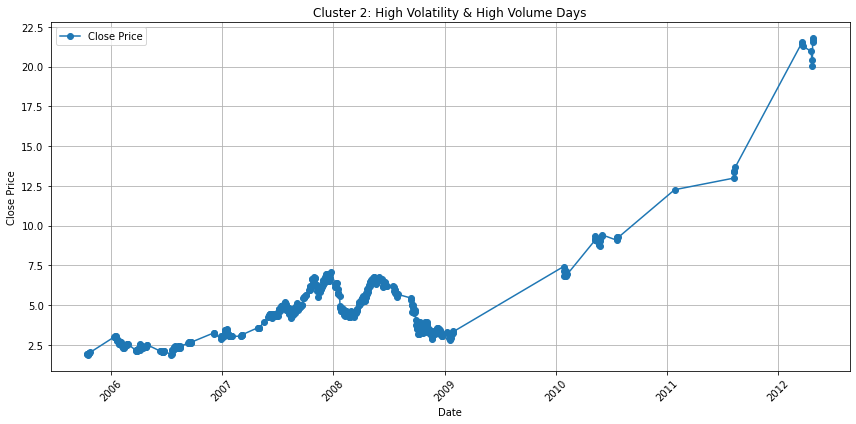

In [0]:
# Define a function to filter, convert, and plot each cluster
def plot_cluster(result_df, cluster_num, title):
    cluster_days = result_df.filter(result_df.prediction == cluster_num) \
                            .select("Date", "close", "return", "volatility_30", "volume_ma_7")
    cluster_pd = cluster_days.toPandas()

    # Convert and sort by date
    cluster_pd['Date'] = pd.to_datetime(cluster_pd['Date'])
    cluster_pd.sort_values('Date', inplace=True)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(cluster_pd['Date'], cluster_pd['close'], label='Close Price', marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot each cluster separately
plot_cluster(result, 0, 'Cluster 0: Neutral/Stable Days')
plot_cluster(result, 1, 'Cluster 1: Low Activity Days')
plot_cluster(result, 2, 'Cluster 2: High Volatility & High Volume Days')

Cluster 0 (3044 days) represents the most frequent market condition for Apple stock, characterized by relatively neutral trends, average volume and volatility. These days reflect stable periods without significant disruptions.

Cluster 1 (1479 days) corresponds to periods of low market activity, marked by low return variability. Such periods often happen during holidays or in between major events. 

Cluster 2 (503 days) includes days with high volatility and high trading volume. These are the most intense and active periods in Apple’s stock history. Prices changed a lot, and many shares were bought and sold. This cluster contains major events.



In [0]:
cluster_2_days = result.filter(result.prediction == 0).select("Date", "close", "return", "volatility_30", "volume_ma_7")
cluster_2_days.show(10)  

+-------------------+------------------+--------------------+--------------------+-----------+
|               Date|             close|              return|       volatility_30|volume_ma_7|
+-------------------+------------------+--------------------+--------------------+-----------+
|2005-07-29 00:00:00|1.5232142857142856|-0.02089072543618...|0.015450030102641272| 3.224352E8|
|2005-08-01 00:00:00|1.5267857142857142|0.003521126760563...| 0.01562991414233609| 3.379616E8|
|2005-08-02 00:00:00|            1.5425|0.006994637444625762|0.015595225468674314| 3.251024E8|
|2005-08-03 00:00:00|1.5435714285714286|6.946052326927793E-4|0.015549230084953325|  3.24498E8|
|2005-08-04 00:00:00|1.5253571428571429|-0.00628199162401...|0.015545910273352864| 3.193116E8|
|2005-08-05 00:00:00|1.5353571428571429|0.011767474699929352|0.015579957815270084| 3.194132E8|
|2005-08-08 00:00:00|1.5232142857142856|-0.00813953488372...|0.015691765601566935| 3.134392E8|
|2005-08-09 00:00:00|             1.565| 0.0207314

This cluster captures days with intense trading activity and price swings — often driven by earnings, product launches, or external shocks.
Cluster 2 shows  key transitions in Apple’s stock fluctuations, such us:
-  2008 which is the year of financial crisis, when Apple experienced significant volatility and short-term corrections.
- The 2009–2012 recovery and acceleration, reflecting renewed investor confidence, strong iPhone sales, and a wave of innovation.

Moreover, specific periods in the cluster reflects  The Milestones of Apple such us price movements during earlyiPhone relases(2007-2009), significant growth in the period from 2010-2012 when the iPad was launched (2010) and apple became more popular globally. 

Source: https://www.officetimeline.com/blog/apple-inc-timeline


## Spark SQL example

In real word scenarios, SQL allows to exploer and summarize easly datasets with many records. Therefore, we decided to demonstrate a simple example of creating a SQL table from a Spark DataFrame using our dataset. This implementation makes further analysis easier to business users. 

In [0]:
# Creating a SQL table from the spark_df
spark_df.createOrReplaceTempView("stock_data")

In [0]:
%sql
select * from stock_data 
limit 10 

Date,open,high,low,close,volume,return,log_return,volatility_30,ma_7,ma_30,volume_ma_7,SMA_14,EMA_14
2005-06-03T00:00:00.000+0000,1.3628571428571428,1.377857142857143,1.3489285714285715,1.3657142857142859,9.568692E8,0.002096436058700398,-0.0459968662638191,0.007444387042825286,1.434642857142857,1.434642857142857,4.138932E8,1.3657142857142859,1.3657142857142859
2005-06-06T00:00:00.000+0000,1.3689285714285713,1.3796428571428572,1.3414285714285714,1.3542857142857143,8.119664E8,-0.010696582311505214,-0.008403410796379615,0.00552697058445035,1.4116666666666668,1.4116666666666668,5.948852E8,1.36,1.3641904761904764
2005-06-07T00:00:00.000+0000,1.342857142857143,1.3475,1.3017857142857143,1.305,7.452648E8,-0.028191489361702255,-0.037071126436960485,0.008641120560452588,1.3973214285714286,1.3973214285714286,6.491555E8,1.3416666666666668,1.3562984126984128
2005-06-08T00:00:00.000+0000,1.3082142857142858,1.3303571428571428,1.3060714285714285,1.3185714285714287,4.040064E8,0.00791700791700799,0.010345858684790996,0.014798858167481596,1.3788571428571428,1.3788571428571428,6.6837736E8,1.3358928571428572,1.3512681481481483
2005-06-09T00:00:00.000+0000,1.3214285714285714,1.355,1.314957142857143,1.344642857142857,3.902556E8,0.017567567567567506,0.019579544611251058,0.01430217103730032,1.3688095238095237,1.3688095238095237,6.243155333333334E8,1.3376428571428574,1.3503847760141094
2005-06-10T00:00:00.000+0000,1.3357142857142856,1.3357142857142856,1.2685714285714287,1.2789285714285714,6.789328E8,-0.04251336898395717,-0.05010577023556116,0.015222472487994026,1.3653571428571427,1.3653571428571427,5.908784E8,1.327857142857143,1.3408572820693712
2005-06-13T00:00:00.000+0000,1.2817857142857143,1.3074999999999999,1.2792857142857144,1.282142857142857,4.357724E8,2.786291446084211E-4,0.0025101114838916865,0.02055739794411013,1.3424489795918366,1.3545535714285712,6.230384E8,1.321326530612245,1.3330286920791694
2005-06-14T00:00:00.000+0000,1.2860714285714285,1.2910714285714284,1.2767857142857142,1.2857142857142858,3.478468E8,-2.777006387113645E-4,0.002781642961876992,0.01932505450469626,1.321326530612245,1.3465079365079362,6.318668E8,1.3168750000000002,1.3267201045638517
2005-06-15T00:00:00.000+0000,1.3167857142857142,1.332142857142857,1.2964285714285713,1.3260714285714286,5.633432E8,0.007051803634391147,0.030906329732878733,0.01827673783386689,1.3098979591836737,1.3404285714285713,5.448636E8,1.3178968253968255,1.3266336144315285
2005-06-16T00:00:00.000+0000,1.3282142857142856,1.3599999999999999,1.315,1.3564285714285713,5.476744E8,0.021242269427265422,0.02263443719515107,0.01767806274446977,1.3058673469387756,1.3391233766233765,5.09346E8,1.3217500000000002,1.3306062753644676


example implementation of the  SQL table

In [0]:
%sql
-- Yearly average close price
select year(date) as year, 
      round(AVG(close),2) AS Avg_Close, 
      round(MAX(high),2) AS Max_High, 
      round(MIN(low),2) AS Min_Low
from stock_data
group by year 
order by year

year,Avg_Close,Max_High,Min_Low
2005,1.86,2.7,1.27
2006,2.53,3.33,1.79
2007,4.58,7.25,2.93
2008,5.07,7.15,2.83
2009,5.24,7.64,2.79
2010,9.28,11.67,6.79
2011,13.0,15.24,11.09
2012,20.57,25.18,14.61
2013,16.88,20.54,13.75
2014,23.07,29.94,17.63


In [0]:
%sql
-- Market risk changes over years
select year(date) as year, round(AVG(volatility_30),4) AS avg_volatility
from stock_data
group by year
order by year

year,avg_volatility
2005,0.0191
2006,0.0194
2007,0.0195
2008,0.0299
2009,0.0173
2010,0.0139
2011,0.0131
2012,0.0139
2013,0.0136
2014,0.0104


In [0]:
%sql
-- How often did markets enter "crisis mode"?
select year(date) as year, count(*) as high_vol_days
from stock_data
where volatility_30 > 0.02
group by year
order by year

year,high_vol_days
2005,40
2006,116
2007,121
2008,206
2009,74
2010,1
2012,23
2013,2
2015,30
2018,3


<br> The number of high-volatility days varied significantly by year.
* Peaks in 2008, 2020, and 2022 stand out, corresponding to known market stress events:
- 2008 – Global Financial Crisis
- 2020 – COVID-19 pandemic onset
- 2022 – Post-pandemic inflation shock, Fed rate hikes, and global uncertainty
<br> In calmer years (e.g., 2013–2017), the number of high-volatility days was very low or close to zero, reflecting periods of market stability.


In [0]:
%sql
-- Show days in 2025 where SMA_14 crossed over EMA_14 (a typical buy signal in technical analysis):
select CAST(Date AS DATE) AS Date, close, round(SMA_14,2) as SMA_14, round(EMA_14,2) as EMA_14
from stock_data
where SMA_14 > EMA_14 and year(date) == 2025
order by Date

Date,close,SMA_14,EMA_14
2025-01-02,243.85,251.96,243.85
2025-01-03,243.36,251.64,243.78
2025-01-06,245.0,251.41,243.95
2025-01-07,242.21,250.78,243.72
2025-01-08,242.7,250.01,243.58
2025-01-10,236.85,249.21,242.68
2025-01-13,234.4,248.11,241.58
2025-01-14,233.28,246.6,240.47
2025-01-15,237.87,245.35,240.12
2025-01-16,228.26,243.22,238.54


In 2025, the SMA_14 crossed above the EMA_14 on multiple  days between April and May, signaling a period of sustained bullish momentum in Apple’s stock. This trend was followed by a steady price increase. 

## RDD transformation

In [0]:
rdd = spark_df.select("return").rdd.map(lambda row: row[0])

In [0]:
#  Count positive vs negative return days
positive_days = rdd.filter(lambda x: x > 0).count()
negative_days = rdd.filter(lambda x: x <= 0).count()
positive_days_perc = round(positive_days*100/(positive_days+negative_days),2)
negative_days_perc = round(negative_days*100/(positive_days+negative_days),2)

print(f"Positive return days: {positive_days} ({positive_days_perc}%)")
print(f"Negative return days: {negative_days} ({negative_days_perc}%)")


Positive return days: 2595 (51.68%)
Negative return days: 2426 (48.32%)


* Apple’s stock showed positive daily returns slightly more than half the time (51.67%), reflecting its long-term upward trend and consistent performance over the years.

The analysis of 20 years of Apple daily stock returns showed that approximately 52% of trading days had positive returns, while 48% had negative returns. 

In [0]:
extreme_days = rdd.filter(lambda x: abs(x) > 0.05).count()
print(f"Number of extreme move days (>5% or <-5% daily return): {extreme_days}")


Number of extreme move days (>5% or <-5% daily return): 63


In [0]:
def bucket(x):
    if x < -0.05:
        return 'Big Loss'
    elif x < 0:
        return 'Smallx Loss'
    elif x < 0.05:
        return 'Small Gain'
    else:
        return 'Big Gain'

rdd = spark_df.select("return").rdd.map(lambda row: bucket(row[0]))
result = rdd.countByValue()
print(result)


defaultdict(<class 'int'>, {'Small Gain': 2568, 'Smallx Loss': 2390, 'Big Gain': 36, 'Big Loss': 27})


Summary: 
* Most of Apple’s daily returns fall within a ±5% range, with large movements being rare — only 63 extreme days were identified across the entire dataset, highlighting the stock’s overall stability.
* The majority of trading days fall into "Small Gain" (2570 days) and "Small Loss" (2393 days), indicating that Apple's stock typically experiences minor daily fluctuations

## Saving the data for further modelling

In [0]:
spark_df.write.mode("overwrite").saveAsTable("stock_data")